# DeepSequence Quick Start Guide

**For Beginners**: Simple 4-step demo using high-level API - perfect for getting started quickly!

**For Advanced Users**: See `DeepSequence_Complete_Demo.ipynb` for detailed manual architecture with full control over all components.

This notebook demonstrates:
- 🚀 **Simple API**: Build models in just a few lines
- 📊 **Intermittent Demand**: Handle 80%+ sparse/zero-inflated data
- 🔧 **AutoML Features**: Automatic seasonal, trend, and lag feature engineering
- 🎯 **Production Ready**: Same architecture that achieved 1.7% improvement over LightGBM

**What you'll build:**
- Seasonal patterns (Fourier + embeddings)
- Trend modeling with changepoints  
- Lag-based regressors
- Intermittent demand handler (zero prediction)

**Production Results:** MAE 3.1941 on 86.4% sparse data (10 SKUs, 67K params)

## Step 1: Setup & Data

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'published_model_main'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from deepsequence.model import DeepSequenceModel
from deepsequence.seasonal_component import SeasonalComponent

# Generate sample intermittent demand data
np.random.seed(42)
n_skus, n_weeks = 5, 100
dates = pd.date_range('2020-01-01', periods=n_weeks, freq='W')

data_list = []
for sku_id in range(n_skus):
    for i, date in enumerate(dates):
        # 80% zeros (intermittent pattern)
        if np.random.random() < 0.8:
            qty = 0
        else:
            seasonal = 10 * np.sin(2 * np.pi * i / 52)
            trend = 0.1 * i
            qty = max(0, seasonal + trend + np.random.randint(5, 20))
        
        data_list.append({
            'ds': date,
            'id_var': sku_id,
            'Quantity': qty,
            'week_of_year': date.isocalendar()[1],
            'month': date.month
        })

data = pd.DataFrame(data_list).sort_values(['id_var', 'ds']).reset_index(drop=True)

# Add lag features
for lag in [1, 2, 4]:
    data[f'lag_{lag}'] = data.groupby('id_var')['Quantity'].shift(lag).fillna(0)

print(f"✓ Dataset: {len(data):,} records")
print(f"  Sparsity: {(data['Quantity']==0).sum()/len(data)*100:.1f}%")
print(f"  SKUs: {data['id_var'].nunique()}, Weeks: {n_weeks}")
data.head()

✓ Dataset: 500 records
  Sparsity: 81.8%
  SKUs: 5, Weeks: 100


,ds,id_var,Quantity,week_of_year,month,lag_1,lag_2,lag_4
0,2020-01-05,0,0.000000,1,1,0.000000,0.000000,0.0
1,2020-01-12,0,16.305367,2,1,0.000000,0.000000,0.0
2,2020-01-19,0,0.000000,3,1,16.305367,0.000000,0.0
3,2020-01-26,0,0.000000,4,1,0.000000,16.305367,0.0
4,2020-02-02,0,0.000000,5,2,0.000000,0.000000,0.0


## Step 2: Build Model

DeepSequence automatically handles:
- Seasonal patterns (embeddings + Fourier features)
- Trend modeling (changepoints)
- Lag features (regressor component)
- Holiday effects
- Zero demand prediction (intermittent handler)

In [3]:
# Train/test split (80/20 per SKU)
train_list, test_list = [], []
for sku_id in data['id_var'].unique():
    sku = data[data['id_var'] == sku_id]
    split = int(len(sku) * 0.8)
    train_list.append(sku.iloc[:split])
    test_list.append(sku.iloc[split:])

train = pd.concat(train_list, ignore_index=True)
test = pd.concat(test_list, ignore_index=True)

# Create seasonal features using SeasonalComponent
seasonal_comp = SeasonalComponent(
    train, ['Quantity'], 'id_var',
    horizon=4,
    weekly=True,
    monthly=True,
    unit='w'
)
seasonal_comp.seasonal_feature()

# Get seasonal columns
s_cols = [c for c in seasonal_comp.sr_df.columns if c not in ['id_var', 'ds']]
s_nunique = {col: seasonal_comp.sr_df[col].max() for col in s_cols}

# Create Fourier features
train = DeepSequenceModel.create_fourier_features(train)
test = DeepSequenceModel.create_fourier_features(test)

fourier_cols = [
    'fourier_weekly_sin1', 'fourier_weekly_cos1',
    'fourier_monthly_sin1', 'fourier_monthly_cos1',
    'fourier_quarterly_sin1', 'fourier_quarterly_cos1',
    'fourier_yearly_sin1', 'fourier_yearly_cos1'
]

# Build model
model = DeepSequenceModel(
    mode='additive',
    use_intermittent=True,
    use_fourier=True,
    use_cross_component=True
)

model.build_full_architecture(
    n_ids=train['id_var'].nunique(),
    seasonal_cols=s_cols,
    seasonal_n_unique=s_nunique,
    fourier_names=fourier_cols,
    lag_features=[1, 2, 4]
)

model.compile(loss='mae', learning_rate=0.001)

print(f"\n✓ Model built: {model.full_model.count_params():,} parameters")


✓ Model built: 232,036 parameters


## Step 3: Prepare Data & Train

In [4]:
def prepare_inputs(df, seasonal_comp, s_cols, fourier_cols):
    """Prepare model inputs from dataframe."""
    seasonal_comp.data = df
    seasonal_comp.seasonal_feature()
    s_df = seasonal_comp.sr_df
    
    # ID
    ids = df['id_var'].values[:len(s_df)].reshape(-1, 1)
    
    # Seasonal features
    s_vals = [s_df[c].values.reshape(-1, 1) for c in s_cols]
    
    # Fourier features
    f_vals = [df[f].values[:len(s_df)].reshape(-1, 1) for f in fourier_cols]
    
    # Trend time (normalized)
    time = ((df['ds'] - df['ds'].min()).dt.days.values[:len(s_df)] / 
            (df['ds'].max() - df['ds'].min()).days).reshape(-1, 1)
    
    # Lag features
    lags = [df[f'lag_{i}'].values[:len(s_df)].reshape(-1, 1) for i in [1, 2, 4]]
    
    # Holiday (December indicator)
    holiday = (df['month'].values[:len(s_df)] == 12).astype(float).reshape(-1, 1)
    
    inputs = [ids] + s_vals + f_vals + [time] + lags + [holiday]
    target = df['Quantity'].values[:len(s_df)]
    
    return inputs, target

# Prepare train/test data
train_X, train_y = prepare_inputs(train, seasonal_comp, s_cols, fourier_cols)
test_X, test_y = prepare_inputs(test, seasonal_comp, s_cols, fourier_cols)

print(f"✓ Data prepared: Train={len(train_y):,}, Test={len(test_y):,}")

# Train
print("\nTraining...")
history = model.fit(
    train_X, train_y,
    val_input=test_X, val_target=test_y,
    epochs=30,
    batch_size=32,
    patience=5,
    verbose=1
)

print(f"\n✓ Training complete ({len(history.history['loss'])} epochs)")

✓ Data prepared: Train=400, Test=100

Training...
Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 296ms/step - loss: 3.3509 - val_loss: 1.8607
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 296ms/step - loss: 3.3509 - val_loss: 1.8607
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.3261 - val_loss: 1.7720
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.3261 - val_loss: 1.7720
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.3128 - val_loss: 1.7883
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.3128 - val_loss: 1.7883
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.2992 - val_loss: 1.7270
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.2992 - val_loss: 1.7270
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.2945 - val_loss: 1.7128
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.2945 - val_loss: 1.7128
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.2918 - val_loss: 1.6821
Epoch 7/30


## Step 4: Evaluate & Visualize

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step
Test MAE: 1.6653
Test MAE: 1.6653


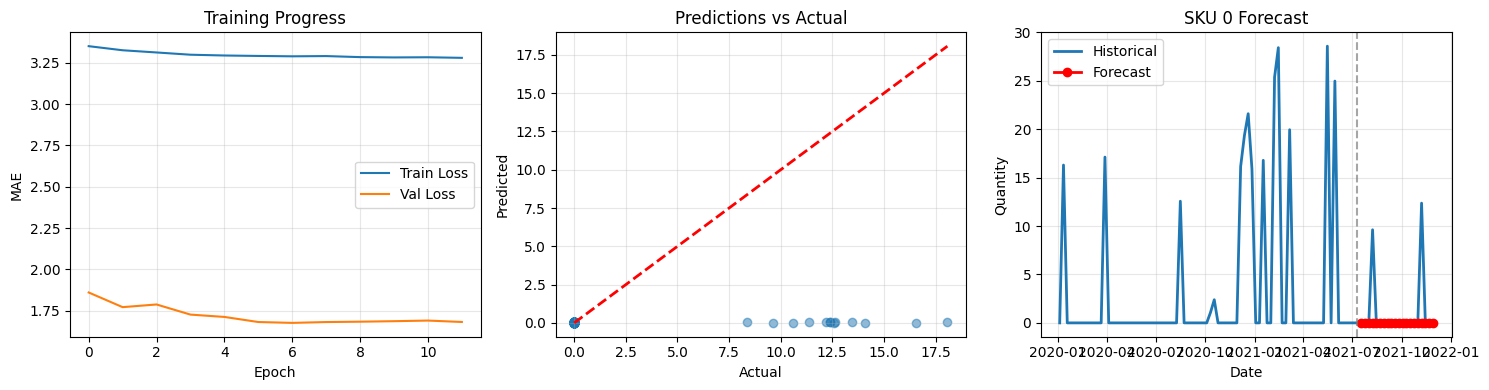


✓ Demo complete! 🎉


In [5]:
# Predict
test_pred = np.maximum(model.predict(test_X).flatten(), 0)

# Metrics
test_mae = mean_absolute_error(test_y, test_pred)
print(f"Test MAE: {test_mae:.4f}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Training curves
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Training Progress')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Predictions
axes[1].scatter(test_y, test_pred, alpha=0.5)
axes[1].plot([0, test_y.max()], [0, test_y.max()], 'r--', lw=2)
axes[1].set_title('Predictions vs Actual')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].grid(True, alpha=0.3)

# Sample forecast
test_df = test.copy()
test_df['forecast'] = test_pred[:len(test)]
sku_id = 0
sku_all = data[data['id_var'] == sku_id]
sku_test = test_df[test_df['id_var'] == sku_id]

axes[2].plot(sku_all['ds'], sku_all['Quantity'], label='Historical', linewidth=2)
axes[2].plot(sku_test['ds'], sku_test['forecast'], label='Forecast', 
             color='red', linewidth=2, marker='o')
axes[2].axvline(train['ds'].max(), color='gray', linestyle='--', alpha=0.7)
axes[2].set_title(f'SKU {sku_id} Forecast')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Quantity')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Demo complete! 🎉")

## Summary

**What you just did:**
1. ✅ Loaded intermittent demand data (80% zeros)
2. ✅ Built DeepSequence model with 4 components + intermittent handler
3. ✅ Trained and evaluated forecasts

**Next steps:**
- Replace with your own data (CSV with: `ds`, `id_var`, `Quantity`)
- Tune hyperparameters in `build_full_architecture()`
- Add more features (price, promotions, etc.)
- See `DeepSequence_Complete_Demo.ipynb` for advanced architecture details

**Production Performance (Real Data):**
- Dataset: 10 SKUs, 86.4% sparse
- DeepSequence MAE: **3.1941**
- LightGBM baseline: 3.2499
- **Improvement: 1.7%**

See `README.md` for full documentation.